In [12]:
%matplotlib inline
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
from skimage import measure # to get contours from masks

import napari

sns.set_theme()

In [13]:
os.chdir("D:/Hugo/Anaphase/Analyse_Descriptive/Data")  # root dir containg Predictions and Images Path

predictions = imageio.volread("S0-50_BFf0001-1-100.tif") # neural network predictions (segmentation)
corresponding_imgs = imageio.volread("BF_f0001-1-100.tif") # bf images
rfp_imgs = imageio.volread("RFP_f0001-1-100.tif") # rfp images

tracks_and_contours = pd.read_csv("Tracking_Results_BF_f0001-1-100.1.csv") # tracking positions and the corresponding contours
contours = np.load("Contours_BF_f0001-1-100.npy", allow_pickle=True)

# a bit dirty... I have to replace the contours in dataframe because if loaded from a csv, it will be a string and not an array
# so we save it as a separate array (but with god rows order, see Perform_Tracking.py) and load and cast it to float-32 (for opencv)
contours32 = []
for c in contours:
    cont = []
    for pos in c:
        cont.append(pos.astype(np.float32))
    contours32.append(np.array(cont))
contours32 = np.array(contours32)

# put the "good" contours i.e. the array, and not the loaded string
# tracks_and_contours = tracks_and_contours.drop("Contours", axis=1)
tracks_and_contours["Contours"] = contours32

print(tracks_and_contours.shape, contours.shape)
tracks_and_contours.head()

(22423, 6) (22423,)


<ipython-input-13-4b89f1d94c67>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  contours32 = np.array(contours32)


,Unnamed: 0,ID,Frame,X,Y,Contours
0,0,36.0,0.0,140.002876,201.506667,"[[149.21568, 205.0], [149.21568, 204.0], [149...."
1,1,36.0,1.0,140.314489,201.636364,"[[150.21568, 204.0], [150.21568, 203.0], [150...."
2,2,36.0,2.0,136.433110,202.240506,"[[146.21568, 206.0], [146.21568, 205.0], [146...."
3,3,36.0,3.0,136.922876,202.680000,"[[146.21568, 207.0], [146.21568, 206.0], [146...."
4,4,36.0,4.0,137.885918,203.155844,"[[147.21568, 207.0], [147.21568, 206.0], [147...."


In [14]:
# retrieve the contours of a specified cell, for all frame
ID = 38
contours = tracks_and_contours[tracks_and_contours["ID"] == ID][["Frame", "Contours"]]
print(contours)

      Frame                                           Contours
1239    0.0  [[177.21568, 326.0], [177.21568, 325.0], [177....
1240    1.0  [[177.21568, 325.0], [177.21568, 324.0], [177....
1241    2.0  [[175.21568, 325.0], [175.0, 324.7843], [174.2...
1242    3.0  [[175.21568, 327.0], [175.21568, 326.0], [175....
1243    4.0  [[175.21568, 327.0], [175.21568, 326.0], [175....
...     ...                                                ...
1334   95.0  [[179.21568, 390.0], [179.21568, 389.0], [179....
1335   96.0  [[181.21568, 392.0], [181.21568, 391.0], [181....
1336   97.0  [[184.21568, 396.0], [184.21568, 395.0], [184....
1337   98.0  [[186.21568, 393.0], [186.21568, 392.0], [186....
1338   99.0  [[187.21568, 394.0], [187.21568, 393.0], [187....

[100 rows x 2 columns]


In [15]:
print(cv2.contourArea(contours["Contours"].to_numpy()[0]))

149.00494826212525


In [16]:
print(0 in tracks_and_contours[(tracks_and_contours["ID"] == 1)]["Frame"].to_numpy())

True


In [17]:
def plot_cells_characteristics(tracks_contours, ID, characteristics=["Surface"]):
    """
    Given the ID of a cell, plots the demanded characteristics over time.
    tracks_contours (pd.DataFrame): df containing the tracks and the contours of all cells at all frames (ID, Frame, X, Y, Contours)
    ID (int): ID of the cell(s) to track. TODO : extend to take a list of IDs instead of a single one.
    characteristics (list<str>): List of the characteristics to plot
    start_frame (int): first frame to display (included)
    end_frame (int): last frame to display (excluded)
    """
    cell = tracks_contours[(tracks_contours["ID"] == ID)]

    fig, ax = plt.subplots(1, len(characteristics), figsize=(20, 10))
    if "Surface" in characteristics:
        surfaces_per_frame = retrieve_surfaces(cell) # dataframe containing the cell's surface over time (frame by frame)
        start_frame, end_frame = 1000, -1
        for ID in pd.unique(surfaces_per_frame["ID"]): # for each cell, plot its surface over time
            start_frame, end_frame = np.min([start_frame, np.min(surfaces_per_frame["Frame"])]), np.max([end_frame, np.max(surfaces_per_frame["Frame"])])
            if len(characteristics) > 1:
                ax[0].plot(surfaces_per_frame["Frame"], surfaces_per_frame["Surface"], label=ID)
                ax[0].set_xlim(left=start_frame, right=end_frame)
                ax[0].set_title(f"Surface of cell {ID} between frame {start_frame} and {end_frame}")
                plt.xticks(range(int(start_frame), int(end_frame) + 1))
            else:
                ax.plot(surfaces_per_frame["Frame"], surfaces_per_frame["Surface"], label=ID)
                ax.set_xlim(left=np.min(surfaces_per_frame["Frame"]), right=np.max(surfaces_per_frame["Frame"]))
                ax.set_title(f"Surface of cell {ID} between frame {start_frame} and {end_frame}")
                plt.xticks(range(int(start_frame), int(end_frame) + 1))

    plt.show()
    return

def retrieve_surfaces(cell):
    """
    Retrieve the surface of a cell, whose contours are given in the dataframe cell.
    cell (pd.DataFrame): df containing the contours of the query cell.
    """
    surfaces_over_time = []
    for i, line in cell.iterrows():
        s = cv2.contourArea(line["Contours"])
        surfaces_over_time.append({"ID": line["ID"], "Frame": line["Frame"], "Surface": s})
    return pd.DataFrame(surfaces_over_time)

In [47]:
# get matplotlib colors
import matplotlib.colors as mcolors

class DivisionEvent:
    """
    An instance of the DivisionEvent class records the features of a division event: mother/daughter cell indices, start frame, anaphase frame and end frame of the record. 
    An instance is created by analyzing the image sequence in Napari, and using the keyboard shortcuts (q: for declaring the mother cell and the start frame(the closest to the mouse cursor), d: for daughter cell, z: anaphase frame (and 
    end frame and append to DataContainer), e: end frame, r: summary the DivisionEvent characteristics and a: append to the DataContainer.)
    """
    
    def __init__(self):
        self.mother_idx = None
        self.daughter_idx = None
        self.anaphase_frame = 0
        self.start_frame = 0
        self.end_frame = 0
        self.anaphase_frame = 0
        self.time_step = 6
        
    def set_mother(self, mother_idx):
        self.mother_idx = mother_idx
        
    def set_daughter(self, daughter_index):
        self.daughter_idx = daughter_index
    
    def set_start_frame(self, start_frame):
        self.start_frame = start_frame
        
    def set_end_frame(self, end_frame):
        self.end_frame = end_frame
        
    def set_anaphase_frame(self, af):
        self.anaphase_frame = af
        
    def set_time_step(self, ts):
        self.time_step = ts
        
class DataContainer:
    """
    The DataContainer instance is a data structure that records the different division events. It is filled using the keyboard shortcuts in Napari : once a DivisionEvent has been instanciated, it is added to the DataContainer using the key
    'a' (for 'append'). Once all the DivisionEvents are added, one can build a structured DataFrame from them ; this dataframe contains several characteristics of interest (surface over time, etc.) that can be added when needed. The Container
    also implements a plot function that allows to view the desired characteristics over time (TODO: extend to other features than relat_surf).
    """
    
    def __init__(self, tracks_contours, auto_save_path="D:/Hugo/Anaphase/Analyse_Descriptive"):
        self.division_events = []
        self.data = None
        self.tracks_contours = tracks_contours
        self.auto_save_path = auto_save_path
        
    def append_division_event(self, div_event):
        self.division_events.append(div_event)
        if len(self.divison_events) % 10 == 0:
            print(f"\nAuto-saving the collected data at '{self.auto_save_path}/auto_save_surfaces_over_time.csv' ...")
            self.build_data()
            self.data.to_csv(f"{self.auto_save_path}/auto_save_surfaces_over_time.csv", sep=";")
            print("Saving done.\n")
        
    def build_data(self):
        
        if self.division_events == []:
            print("No division events added yet!")
            return
        
        data = []
        for idx, ev in enumerate(self.division_events):
            frames = np.arange(ev.start_frame, ev.end_frame)
            
            for f in frames:  # rel : relative time (0 is the first frame etc.)
                time = (f - ev.start_frame) * ev.time_step  # cast frame to relative time reference
                mom_df = self.tracks_contours[(self.tracks_contours["Frame"] == f) & (self.tracks_contours["ID"] == ev.mother_idx)]
                mom_surf = cv2.contourArea(mom_df["Contours"].to_numpy()[0])
                if f in self.tracks_contours[self.tracks_contours["ID"] == ev.daughter_idx]["Frame"].to_numpy(): # if the daughter existed at first frame
                    try:
                        dau_df = self.tracks_contours[(self.tracks_contours["Frame"] == f) & (self.tracks_contours["ID"] == ev.daughter_idx)]
                        dau_surf = cv2.contourArea(dau_df["Contours"].to_numpy()[0])
                    except:
                        dau_df = pd.DataFrame([{"X": -1, "Y": -1, "ID:" -1}]) # to record the false position after
                        dau_surf = 0.0
                else: # convention : the daughter doesn't exist -> daughter surface = 0
                    dau_df = pd.DataFrame([{"X": -1, "Y": -1, "ID": -1}]) # to record the false position after
                    dau_surf = 0.0
                relat_surf = dau_surf / mom_surf
                anaphase_now = False
                if f == ev.anaphase_frame:
                    anaphase_now = True
                time_to_anaphase = (ev.anaphase_frame - ev.start_frame) * ev.time_step - time # positive if has not divided yet
                data.append({"idx": idx, 
                             "frame": f, "time": time,
                             "mom_ID": mom_df["ID"], "daugh_ID": dau_df["ID"],
                             "mom_x": mom_df["X"].to_numpy()[0], "mom_y": mom_df["Y"].to_numpy()[0],  # the position keeps track of which cell it is
                             "daugh_x": dau_df["X"].to_numpy()[0], "daugh_y": dau_df["Y"].to_numpy()[0],
                             "mom_surf": mom_surf, "daugh_surf": dau_surf, 
                             "relat_surf": relat_surf, 
                             "anaphase": anaphase_now,
                             "time_to_anaphase": time_to_anaphase
                            })
        self.data = pd.DataFrame(data).set_index("idx")
        
    def plot_data(self):
        
        if self.data is not None:
            # get matplotlib colors
            by_hsv = [(tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                             name)
                            for name, color in mcolors.TABLEAU_COLORS.items()]
            names = [name for hsv, name in by_hsv]
        
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))

            for idx in self.data.index.unique():
                event = self.data.loc[idx]
                
                # plot surface over time
                ax.plot(event["time"], event["relat_surf"], label=idx, c=names[idx % len(names)])
                
                # plot anaphase moment
                anaphase_moment = event[event["anaphase"]]
                ax.scatter(anaphase_moment["time"], anaphase_moment["relat_surf"], s=20, c=names[idx % len(names)])

            # plot anaphase box
            ax.plot([0, 55], [0.5, 0.5], "--", c="grey")
            ax.plot([0, 55], [0.55, 0.55], "--", c="grey")
            ax.plot([45, 45], [0., 0.6], "--", c="grey")
            ax.plot([55, 55], [0., 0.6], "--", c="grey")

            ax.set_xlabel("time (min)")
            ax.set_ylabel("relative daughter/mom surface")

            ax.set_title("Relative daughter cell / mom cell over time")
#             ax.legend()
            plt.show()
        else:
            print("DataFrame not yet built!")
            
def get_closest_cell(frame, x, y, df=None):
    """
    Find the closest cell to click point
    Return : ID of the track corresponding to the closest cell
    """
    distances = []
    for _, c in tracks_and_contours[tracks_and_contours["Frame"] == frame].iterrows():
        distances.append(np.sqrt((c["X"] - x) ** 2 + (c["Y"] - y) ** 2))
    distances = np.array(distances)
    min_dist, min_dist_arg = np.min(distances), np.argmin(distances)
    if min_dist < 12:
        closest_cell = tracks_and_contours[tracks_and_contours["Frame"] == frame].iloc[min_dist_arg] # retrieve the closes cell
    else: # don't get the closest, the click was just to move on the map
        return -1
    return closest_cell["ID"]

20.0
Added mother cell : 20.0 at frame 0.
Added daughter cell : 48.0.
anaphase frame: 6
end frame: 11
Added division event to DataContainer. Now contains 1 division events.
22.0
Added mother cell : 22.0 at frame 11.
Added daughter cell : 71.0.
anaphase frame: 18
end frame: 23
Added division event to DataContainer. Now contains 2 division events.
48.0
Added mother cell : 48.0 at frame 23.
Added daughter cell : 107.0.
anaphase frame: 32
end frame: 37
Added division event to DataContainer. Now contains 3 division events.
22.0
Added mother cell : 22.0 at frame 34.
Added daughter cell : 147.0.
anaphase frame: 40
end frame: 45
Added division event to DataContainer. Now contains 4 division events.
20.0
Added mother cell : 20.0 at frame 38.
Added daughter cell : 164.0.
anaphase frame: 45
end frame: 50
Added division event to DataContainer. Now contains 5 division events.
48.0
Added mother cell : 48.0 at frame 51.
Added daughter cell : 231.0.
anaphase frame: 57
end frame: 62
Added division even

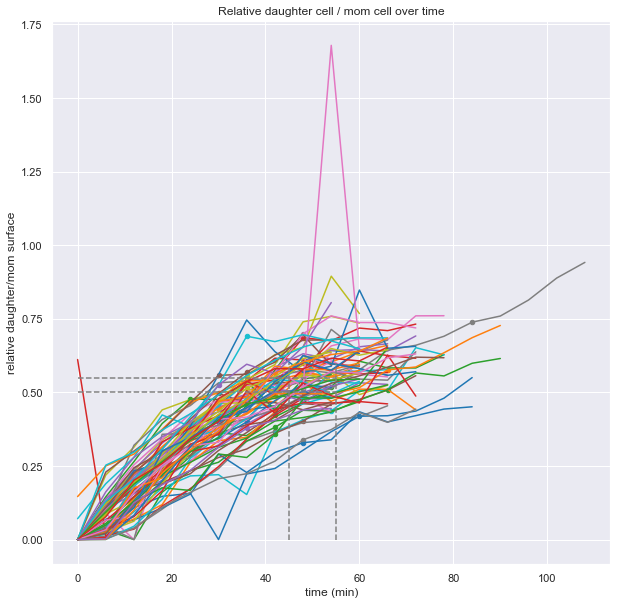

In [48]:
# WARNING Napari : la souris doit etre deplacee pour que sa position soit actualisee entre deux frames!!

resized = []
for im in corresponding_imgs:
    resized.append(cv2.resize(im, (512, 512)))
resized = np.array(resized)

with napari.gui_qt():
    # open napari viewer
    holder = DataContainer(tracks_and_contours)
    viewer = napari.view_image(resized, name="BF Images")
    rfp_layer = viewer.add_image(rfp_imgs, blending="additive", colormap="red", name="RFP Images")
    images_layer = viewer.add_image(predictions, opacity=0.5, colormap="bop blue", blending="additive", name="Predictions")
    viewer.add_tracks(tracks_and_contours[["ID", "Frame", "X", "Y"]], name="Tracks")
    
    # actions
    @viewer.bind_key("q")
    def append_mother_cell(viewer):
        global ev
        frame, x, y = np.round(images_layer.coordinates).astype(int)
        closest_cell = get_closest_cell(frame, x, y, df=holder.tracks_contours)
        
        print(closest_cell)
        
        if closest_cell != -1:
            # create the division event
            ev = DivisionEvent()
            # append the closest cell as the mother cell to the division event
            ev.set_mother(closest_cell)
            ev.set_start_frame(frame)
            print(f"Added mother cell : {ev.mother_idx} at frame {ev.start_frame}.")
        else:
            print("Didn't add any mother cell.")
    
    @viewer.bind_key("d")
    def append_daughter_cell(viewer):
        frame, x, y = np.round(images_layer.coordinates).astype(int)
        closest_cell = get_closest_cell(frame, x, y, df=holder.tracks_contours)
        
        if closest_cell != -1:
            ev.set_daughter(closest_cell)
            print(f"Added daughter cell : {ev.daughter_idx}.")
        else:
            print("Didn't add any daughter cell.")
    
    @viewer.bind_key("s")
    def append_start_frame(viewer):
        frame, x, y = np.round(images_layer.coordinates).astype(int)
        ev.set_start_frame(frame)
        print(f"start frame: {ev.start_frame}")
        
    @viewer.bind_key("z")
    def append_anaphase_frame(viewer):
        frame, x, y = np.round(images_layer.coordinates).astype(int)
        ev.set_anaphase_frame(frame)
        print(f"Anaphase frame: {ev.anaphase_frame}")
        ev.set_end_frame(frame + 5)  # also append end frame
        print(f"End frame : {ev.end_frame}")
        append_division_event(viewer)   # also append the event to the container
        print(f"Added division event to DataContainer. Now contains {len(holder.division_events)} division events.\n")
    
    @viewer.bind_key("f")
    def append_end_frame(viewer):
        frame, x, y = np.round(images_layer.coordinates).astype(int)
        ev.set_end_frame(frame)
        print(f"end frame: {ev.end_frame}")
        
    @viewer.bind_key("r")
    def resume_div_event(viewer):
        print("\n")
        print("=== RESUME ===")
        print(f"Mother cell: {ev.mother_idx}.")
        print(f"Daughter cell: {ev.daughter_idx}.")
        print(f"From frame {ev.start_frame} to frame {ev.end_frame}.")
        print(f"Anaphase frame : {ev.anaphase_frame}.")
        print("\n")
        
    @viewer.bind_key("x")
    def remove_last_element(viewer):
        if holder.division_events != []:
            holder.division_events.pop(-1)
            print("Removed the last added division event.")
        else:
            print("Division events list is empty!")
    
    @viewer.bind_key("a")
    def append_division_event(viewer):
        if ev.mother_idx is not None and ev.daughter_idx is not None and (ev.start_frame != 0 or ev.end_frame != 0) and ev.anaphase_frame != 0:
            holder.append_division_event(ev)
            print(f"Added division event to DataContainer. Now contains {len(holder.division_events)} division events.\n")
        else:
            print("The division event is not full.")
            resume_div_event(viewer)
        
    @viewer.bind_key(".")
    def build_data(viewer):
        print("Building dataframe...")
        holder.build_data()
        print("Dataframe built.")
        
    @viewer.bind_key("p")
    def plot_data(viewer):
        print("Plotting Data...")
        holder.plot_data()
    

## Investigate measures

In [102]:
os.chdir("D:/Hugo/Anaphase/Analyse_Descriptive/")
data = pd.read_csv("Analysis_BF_f0001-1-100.csv", sep=";", index_col="idx")
print(data.shape)

# drop aberrant line
data = data.drop(56)
print(data.shape)

# mean trajectory per time step
means_over_time = data.groupby("time")["relat_surf"].mean()
means_dividing_cells, std_dividing_cells = data[data["anaphase"]].groupby("time")["relat_surf"].mean(), data[data["anaphase"]].groupby("time")["relat_surf"].std()
std_over_time = data.groupby("time")["relat_surf"].std() * 2

print(data[data["anaphase"]].groupby("time")["relat_surf"].mean())

(884, 10)
(873, 10)
time
24    0.472977
30    0.444988
36    0.505698
42    0.484198
48    0.523662
54    0.478424
60    0.418923
66    0.542762
84    0.738409
Name: relat_surf, dtype: float64


In [266]:
indices = data[(data["anaphase"]) & (data["time"] > 60)].index
print(indices)
data = data.drop(indices, axis=0)
print(data.shape)

Int64Index([27, 42, 61], dtype='int64', name='idx')
(764, 12)


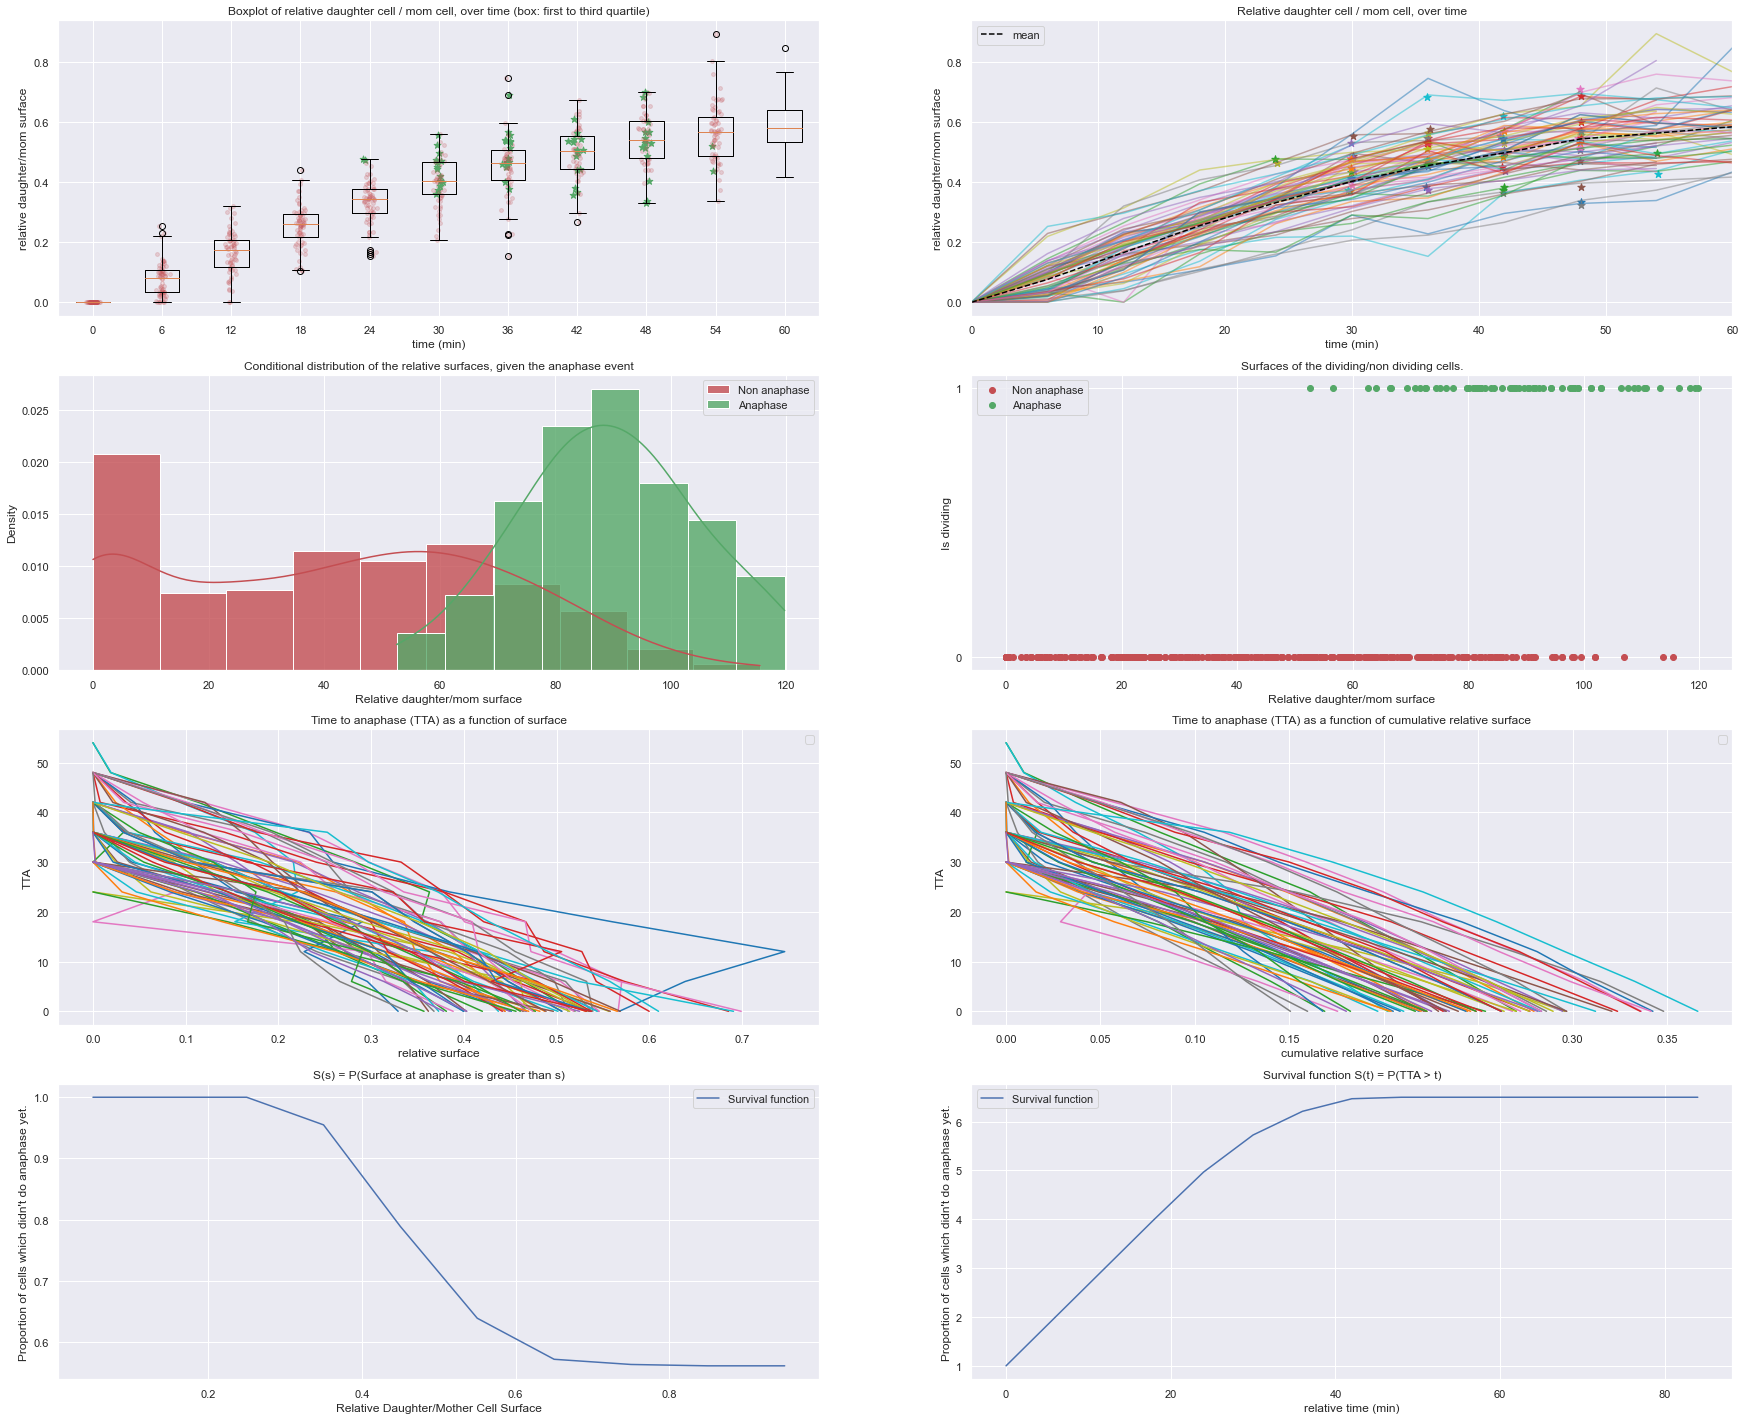

In [330]:
import matplotlib
matplotlib.rcParams['text.usetex'] = False

# get matplotlib colors
by_hsv = [(tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                 name)
                for name, color in mcolors.TABLEAU_COLORS.items()]
names = [name for hsv, name in by_hsv]

fig, ax = plt.subplots(4, 2, figsize=(30, 25))

# plot the mean and std
# ax[1].plot(data["time"].unique(), means_over_time, c="b", label="All cells")
# ax[1].fill_between(data["time"].unique(), means_over_time - std_over_time, means_over_time + std_over_time, color="b", alpha=0.5)
# ax[1].plot(data[data["anaphase"]]["time"].unique(), means_dividing_cells, c="r", label="Dividing cells only")
# # ax[1].fill_between(data[data["anaphase"]]["time"].unique(), means_dividing_cells - std_dividing_cells, means_dividing_cells + std_dividing_cells, color="r", alpha=0.5)
# ax[1].legend()

# make boxplot on the first axis
vals, anaph, times, xs = [], [], [], []
for i, time in enumerate(data["time"].unique()):
    if time < 65: # do not append outliers
        d = data[data["time"] == time]
        vals.append(d["relat_surf"].values)
        anaph.append(d["anaphase"].values)
        times.append(str(time))
        xs.append(np.random.normal(i + 1, 0.04, d["relat_surf"].values.shape[0]))  # adds jitter to the data points - can be adjusted
    
ax[0][0].boxplot(vals, labels=times)
ax[0][0].set_ylabel("relative daughter/mom surface")
ax[0][0].set_title("Boxplot of relative daughter cell / mom cell, over time (box: first to third quartile)")


for x, val, an, col in zip(xs, vals, anaph, names):  # add scatter plots to on the boxplots
    for jitter, v, a in zip(x, val, an):
        if a:
            ax[0][0].scatter(jitter, v, alpha=1, c="g", s=50, marker="*")
        else:
            ax[0][0].scatter(jitter, v, alpha=0.2, c="r", s=15)
    
ax[0][0].set_xlabel("time (min)")

# plot individual trajectories on the second axis
for idx in data.index.unique():
    event = data.loc[idx]

    # plot surface over time
#     if event[event["time"] == 6]["relat_surf"].values[0] > 0.2:
    ax[0][1].plot(event["time"].unique(), event["relat_surf"], c=names[idx % len(names)], alpha=0.5)

    # plot anaphase moment
    dx, dy = np.random.normal(0, 0.1, 1), np.random.normal(0, 0.01, 1)
    anaphase_moment = event[event["anaphase"]]
#     if event[event["time"] == 6]["relat_surf"].values[0] > 0.2:
    ax[0][1].scatter(anaphase_moment["time"] + dx, anaphase_moment["relat_surf"] + dy, marker="*", s=60, c=names[idx % len(names)])
    
ax[0][1].plot(data["time"].unique(), data.groupby("time")["relat_surf"].mean(), "--", c="black", label="mean")

ax[0][1].legend()
ax[0][1].set_xlim(0, 60)
ax[0][1].set_xlabel("time (min)")
ax[0][1].set_ylabel("relative daughter/mom surface")
ax[0][1].set_title("Relative daughter cell / mom cell, over time")


# Conditional distributions on the third axis
will_divide = data[data["time_to_anaphase"] > 0]
is_dividing = data[data["time_to_anaphase"] == 0]

sns.histplot(will_divide["daugh_surf"].values, label="Non anaphase", color="r", alpha=0.8, kde=True, ax=ax[1][0], stat="density")
sns.histplot(is_dividing["daugh_surf"].values, label="Anaphase", color="g", alpha=0.8, kde=True, ax=ax[1][0], stat="density")
ax[1][0].legend()
ax[1][0].set_xlabel("Relative daughter/mom surface")
ax[1][0].set_title("Conditional distribution of the relative surfaces, given the anaphase event")
# ax[1][0].set_xlim(0, 1.0)

# scatter plot on the last axis
ax[1][1].scatter(will_divide["daugh_surf"], [0 for i in range(will_divide["daugh_surf"].shape[0])], c="r", label="Non anaphase")
ax[1][1].scatter(is_dividing["daugh_surf"], [1 for i in range(is_dividing["daugh_surf"].shape[0])], c="g", label="Anaphase")
ax[1][1].legend()
ax[1][1].set_xlabel("Relative daughter/mom surface")
ax[1][1].set_ylabel("Is dividing")
ax[1][1].set_yticks([0, 1])
ax[1][1].set_title("Surfaces of the dividing/non dividing cells.")

# Time-to-anaphase (TTA) as a function of the feature (relative surface)
for idx in data.index.unique():
    event = data.loc[idx]
    
    # plot surface over time
    ax[2][0].plot(event[event["time_to_anaphase"] >= 0]["relat_surf"], event[event["time_to_anaphase"] >= 0]["time_to_anaphase"], c=names[idx % len(names)], alpha=1)
    
ax[2][0].legend()
ax[2][0].set_xlabel("relative surface")
ax[2][0].set_ylabel("TTA")
ax[2][0].set_title("Time to anaphase (TTA) as a function of surface")

# plot TTA=f(cumulative surfaces) 
for idx in data.index.unique():
    event = data.loc[idx]
    
    # plot cumulative surface over time
    cumulative_surfaces = [np.sum(event[(event["time_to_anaphase"] >= t)]["daugh_surf"]) / np.sum(event[(event["time_to_anaphase"] >= t)]["mom_surf"]) for t in event[event["time_to_anaphase"] >= 0]["time_to_anaphase"]]
    ax[2][1].plot(cumulative_surfaces, event[event["time_to_anaphase"] >= 0]["time_to_anaphase"], c=names[idx % len(names)], alpha=1)
    
ax[2][1].legend()
ax[2][1].set_xlabel("cumulative relative surface")
ax[2][1].set_ylabel("TTA")
ax[2][1].set_title("Time to anaphase (TTA) as a function of cumulative relative surface")

# plot TTA=f(cumulative surfaces) 
proportion_of_preevent = []
total_number_of_events = data.index.unique().shape[0]
step = 0.
while step < 0.9:
    at_this_surf = data[data["relat_surf"] < step + 0.1]
    pre_event, divided = at_this_surf[at_this_surf["time_to_anaphase"] > 0], at_this_surf[at_this_surf["time_to_anaphase"] <= 0]
    proportion_of_preevent.append(pre_event.shape[0] / (pre_event.shape[0] + divided.shape[0]))  # proportion of cells which didn't divide yet
    step += 0.1
    
ax[3][0].plot([0.1 * k + 0.05 for k in range(10)], proportion_of_preevent, label="Survival function")

ax[3][0].legend()
ax[3][0].set_xlabel("Relative Daughter/Mother Cell Surface")
ax[3][0].set_ylabel("Proportion of cells which didn't do anaphase yet.")
ax[3][0].set_title("S(s) = P(Surface at anaphase is greater than s)")

# Survival time distribution estimation : P(S > t)_{t >= 0}
proportion_of_preevent = []
total_number_of_events = data.index.unique().shape[0]
for t in data["time"].unique():
    at_this_time = data[data["time"] <= t]
    pre_event, divided = at_this_time[at_this_time["time_to_anaphase"] > 0], at_this_time[at_this_time["time_to_anaphase"] <= 0]
    proportion_of_preevent.append(pre_event.shape[0] / total_number_of_events)  # proportion of cells which didn't divide yet
    
ax[3][1].plot(data["time"].unique(), proportion_of_preevent, label="Survival function")

ax[3][1].legend()
ax[3][1].set_xlabel("relative time (min)")
ax[3][1].set_ylabel("Proportion of cells which didn't do anaphase yet.")
ax[3][1].set_title("Survival function S(t) = P(TTA > t)")

os.chdir("D:/Hugo/Anaphase/Analyse_Descriptive/")
plt.savefig("Description_BF_f0001_division_events.pdf", format="pdf")

## Save Measures

In [299]:
save_path = "D:/Hugo/Anaphase/Analyse_Descriptive/Analysis_BF_f0001-1-100.1.csv"
data.to_csv(save_path, sep=";")